In [129]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import random
#!pip install pythermalcomfort
from pythermalcomfort.models import pmv_ppd
from sklearn.preprocessing import KBinsDiscretizer
tempBins = KBinsDiscretizer(n_bins=31, encode='ordinal', strategy='uniform')
tempBins.fit(np.linspace(15, 30, 30).reshape(-1,1))
pmvBins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
pmvBins.fit(np.linspace(-3.5, 3.5, 15).reshape(-1,1))

def logPlot():
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    x0 = np.linspace(0, len(score0), len(score0))
    sns.lineplot(x0, score0, ax=ax[0])
    ax[0].set(xlabel='Episodes', ylabel='Reward')
    task = []
    reward = []
    r = 0
    for i in H.log_task[:5000]:
        if i[0] in [3, 4, 5]:
            task.append(3)
            reward.append(i[5])
        else:
            task.append(i[0])
            reward.append(i[2])
    x = np.linspace(0, len(task), len(task))
    ax[1].grid(False)
    sns.lineplot(x, task, ax=ax[1], linewidth=2, color='black')
    ax2 = ax[1].twinx()
    ax2.grid(True)
    sns.lineplot(x, reward, ax=ax2, linewidth=2, color='green')
    ax[1].set_xlabel('States')
    ticks = [3, 2, 1, 0]
    labels = ['Change Temp','Task 2','Task 1','Task 0']
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax2.set(ylabel='Reward/ CostL In Green')
    prev = -1

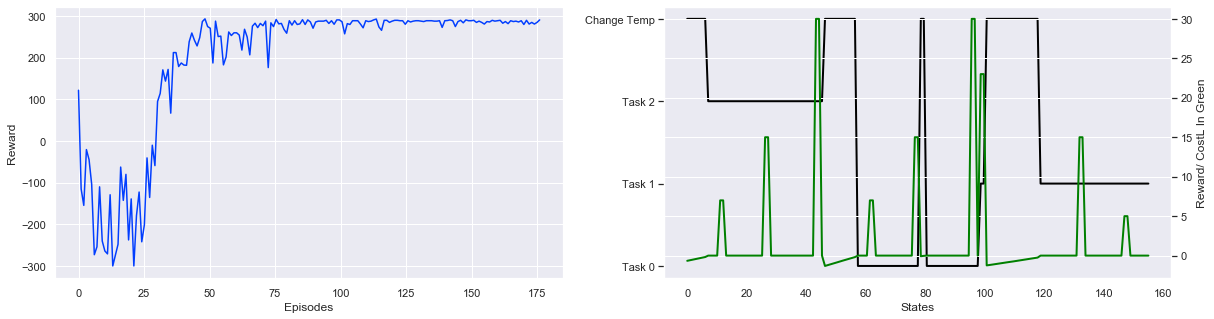

In [108]:
logPlot()

In [ ]:
class Environment:
    def __init__(self):
        self.thermo_switch = 0        #Heater Switch 
        self.curr_temp = 15       #Current Temperature
        self.temp_max = 30   #Maximum Temperature
        self.room_temp = random.randint(18, 25)   #Minimum Temperature --> Room Temperature
        
        self.humid_switch = 0       #Humidifier Switch
        self.curr_humid = 30   #Current Humidity
        self.humid_max = 100  #Maximum Humidity 
        self.room_humid = 100*(math.exp((17.625*15)/(243.04+15))/math.exp((17.625*self.room_temp)/(243.04+self.room_temp)))  #Minimum Humidity --> Surroundings
        
        self.dewpoint = 5    #Dewpoint Temperature --> Doesn't change frequently, hence fixed
        self.epsilon_t = 1   #Initial Epsilon For Temperature Agent
        self.epsilon_h = 1   #Initial Epsilon For Humidity Agent
        self.timer = 1       #Counter For time elapsed
        self.elapse_time_t = 0     #Temperature when heater was last switched
        self.elapse_time_h = 0 # Humidity when humidifier was last switched
        self.thermo_switch_prev = 0       #Temperature at the previous iteration of switch
        self.humid_prev = 0      #Humidity at the previous iteration of switch
        self.t0 = self.room_temp  #Elapsed Time since last switch for Temp AGent
        self.h0 = self.room_humid #Elapsed Time since last switch for Humid Agent
        self.set_temp = 20
        self.set_humidity = 30
        
    def __sensor_readings(self):
        
        # If the heater switch has changed get the elapsed time and temperature of previous iteration
        if self.thermo_switch != self.thermo_switch_prev and self.thermo_switch != 2: 
            self.elapse_time_t = self.timer - 1
            self.t0 = self.curr_temp
        
        # If the humidifier switch has changed get the elapsed time and temperature of previous iteration
        if self.humid_switch != self.humid_prev and self.humid_switch != 2:
            self.elapse_time_h = self.timer - 1
            self.h0 = self.curr_humid
            
        ## Newton's Law of Cooling in a specific medium
        self.t1 = min(self.temp_max - (self.temp_max - self.t0)*math.exp(-self.timer/4 + self.elapse_time_t/4), self.set_temp)
        self.t2 = max(self.room_temp + (self.t0 - self.room_temp)*math.exp(-self.timer/16 + self.elapse_time_t/16), self.set_temp)
        
        ## Convection Law Governing Humidity change
        self.h1 = min(self.humid_max - (self.humid_max - self.h0)*math.exp(-self.timer/16 + self.elapse_time_h/16), self.set_humidity)
        self.h2 = max(self.room_humid + (self.h0 - self.room_humid)*math.exp(-self.timer/4 + self.elapse_time_h/4), self.set_humidity)
        
        ## If heater is ON select t1 temperature else t2
        if self.thermo_switch==0:
            self.curr_temp = self.t1
        elif self.thermo_switch==1:
            self.curr_temp = self.t2 
        elif (self.thermo_switch_prev==0 and self.thermo_switch==2):
            self.curr_temp = self.t1
        else:
            self.curr_temp = self.t2
            
        if self.humid_switch==0:
            self.curr_humid = self.h1
        elif self.humid_switch==1:
            self.curr_humid = self.h2 
        elif (self.humid_prev==0 and self.humid_switch==2):
            self.curr_humid = self.h1
        else:
            self.curr_humid = self.h2

        #Store the switches        
        self.thermo_switch_prev = self.thermo_switch if self.thermo_switch!=2 else self.thermo_switch_prev
        self.humid_prev = self.humid_switch if self.humid_switch!=2 else self.humid_prev
        
        #Timer
        self.timer += 1
        #Limit Humidity and Temperature for Practical Purpose
        self.curr_humid = max(min(self.curr_humid, self.humid_max), self.room_humid)
        self.curr_temp = max(min(self.curr_temp, self.temp_max), self.room_temp)
        #print(self.curr_temp, self.curr_humid)
        return self.curr_temp, self.curr_humid
    
    def step(self, action):
        self.thermo_switch = action[0]
        self.humid_switch = action[1]
        if self.thermo_switch==0:
            self.set_temp = self.set_temp + 0.5
        elif self.thermo_switch==1:
            self.set_temp = self.set_temp - 0.5
        else:
            self.set_temp

        self.set_temp = min(max(18, self.set_temp), 30)          #Thermostat Limit
        
        if self.humid_switch==0:
            self.set_humidity = self.set_humidity + 1 
        elif self.humid_switch==1:
            self.set_humidity = self.set_humidity - 1 
        else:
            self.set_humidity 
            
        self.set_humidity = min(max(30, self.set_humidity), 90)  #Humidifier Limit
        temp, hum = 0.0, 0.0
        for i in range(1):
            temp, hum = self.__sensor_readings()
        return temp, hum#, self.general_pmv(temp, hum)
    
    def reset(self): #Resets the environment to room temperature, room humidity
        self.curr_temp = self.room_temp
        self.curr_humid = self.room_humid
        return self.curr_temp, self.curr_humid#, self.general_pmv(self.curr_temp, self.curr_humid)
    
    def general_pmv(self, temp, hum):
        pmv = pmv_ppd(tdb=temp, tr=25, vr=0.0, rh=hum, met=1, clo=0.5, wme=0, standard="ASHRAE")['pmv']
        return pmv

In [306]:
statemap = []
j = -3
k = 0
while True:
    for i in range(40):
        #tempState = tempBins.transform(np.array([j]).reshape(-1, 1))
        pairState = str(int(j*10)) + str(i)
        #print(j, i, pairState)
        k += 1
        statemap.append(int(pairState))
    j += 0.5
    if j==3.5:
        break
#print(len(statemap), k)

class Human:
    def __init__(self, statemap, lr=0.01, gamma=0.99, r_lr=0.8):
        self.temp = 0
        self.pA_npA = nA = 16 #Root + Phy + Watch + P_Cont + P_Leave + W_Cont + W_Leav
        self.statespace = SS = 2000
        self.Qr = np.zeros((nA, SS))
        self.Qc = np.zeros((nA, SS, nA))
        self.Qe = np.zeros((nA, SS, nA))
        self.epsilon = 0.1
        self.valid_actions = []
        self.alpha = lr
        self.alpha_0 = lr
        self.r_lr = r_lr
        self.gamma = gamma
        self.sum = 0
        self.done = False
        self.statemap = statemap
        self.time = [0, 0, 0]
        self.nState = [0, 0, 0, 0, 0, 0]
        self.reward = 0
        self.log_task = []
        self.QrCopy = self.Qr.copy()
        self.taskStack = []
        self.actionStack = []
        self.pmv = [-1, -1, -1]
        self.ticks = 0
        self.prev = 0
        self.act0 = []
        self.act1 = []
        self.act2 = []
        self.taskMemory = set()
        self.hum = 50
        self.countdown = 170
    
        activity0 = self.task0 = 0  # Non Primitive Action
        activity1 = self.task1 = 1  # Non Primitive Action
        activity2 = self.task2 = 2  # Non Primitive Action
        set0 = self.set0 = 3    # Non Primitive Action
        set1 = self.set1 = 4    # Non Primitive Action
        set2 = self.set2 = 5    # Non Primitive Action
        root = self.root = 6    # Non Primitive Action
        t0h0 = self.t0h0 = 7    # Primitive Action
        t0h1 = self.t0h1 = 8    # Primitive Action
        t1h0 = self.t1h0 = 9    # Primitive Action
        t1h1 = self.t1h1 = 10   # Primitive Action
        cont = self.cont = 11   # Primitive Action
        leave = self.leave = 12 # Primitive Action

        self.graph = [
            (cont, leave, set0), # Activity 0
            (cont, leave, set1), # Activity 1
            (cont, leave, set2), # Activity 2
            (t0h0, t0h1, t1h0, t1h1), # Set Temperature First then run on the treadmill
            (t0h0, t0h1, t1h0, t1h1),
            (t0h0, t0h1, t1h0, t1h1),
            (activity0, activity1, activity2), #Root --> Physical Activity, Watching TV
            set(), #Leave
            set(), #Cont
            set(), # Temp1
            set(), # Temp2
            set(),
            set()
        ]

    def reset(self, temp):
        self.temp = random.randint(16, 27)
        self.hum = int(random.choice([i for i in range(30, 70, 5)]))
        self.time = [0, 0, 0]
        self.nState = [0, 0, 0, 0, 0, 0]
        self.prev = 0
        self.sum = 0
        self.done = False
        self.log_task = []
        self.taskStack = []
        self.actionStack = []
        self.pmv = [-1, -1, -1]
        self.ticks = 0
        self.act0 = []
        self.act1 = []
        self.act2 = []
        self.taskMemory = set()
        self.countdown = 170

    def getPmv(self, temp, hum, task):
        metabolic = [1, 2, 1.4]
        pmv =  pmv_ppd(tdb=temp, tr=25, vr=0.0, rh=hum, met=metabolic[task], clo=0.5, wme=0, standard="ASHRAE")['pmv']
        terminal = 0 if -0.5<=pmv<=0.5 else -1 if (0.5<pmv<=1 or -1<=pmv<-0.5) else -2 if(1<pmv<=1.5 or -1.5<=pmv<-1) else -3
        return terminal, pmv

    def getState(self, time, task):
        metabolic = [1, 2, 1.4]
        pmv =  pmv_ppd(tdb=self.temp, tr=25, vr=0.0, rh=self.hum, met=metabolic[task], clo=0.5, wme=0, standard="ASHRAE")['pmv']
        pmv_state = round(pmv*2)/2
        return statemap.index(int(str(int(pmv_state*10)) + str(time)))

        
    def cost(self, time, task):
        p0 = [2 if 0<=i<7 else 6 if 7<i<22 else 15 if 22<i<39 else 0 for i in range(40)]
        p1 = [1.5 if(0<=i<8 or 18<i<26) else 6.5 if(25<i<33) else 0 if (i==18 or i==33 or i==39) else 0.5 if i>33 else 5 for i in range(40)]
        p2 = [2 if 0<=i<7 else 6 if 7<i<22 else 15 if 22<i<39 else 0 for i in range(40)]
        penalty = [p0, p1, p2]
        return -penalty[task][time]
    
    def task_0(self, action):
        reward = [0 for i in range(40)]
        penalty = [2 if 0<=i<7 else 15 if 7<i<22 else 6 if 22<i<39 else 0 for i in range(40)]
        reward[5], reward[6], reward[20], reward[21], reward[37], reward[38], reward[39] = 7, 7, 30, 30, 15, 15, 0

        if action==self.cont:
            if self.time[0] == 39:
                self.done = True
                self.taskMemory.add(0)
            else:
                self.time[0] += 1
                self.nState[0] = self.getState(self.time[0], 0)
                self.reward = reward[self.time[0]]+self.getPmv(self.temp, self.hum, 0)[0]
                self.done = False
        elif action==self.leave:
            self.reward = -penalty[self.time[0]]
            self.done = True
    
    def task_1(self, action):
        rew = 25
        reward = []
        for i in range(40):
            if ((i-1)%15==0 or (i-1)%15==1):
                reward.append(rew)
                if (i-1)%15==1:
                    rew = max(rew-10, 0)
            else:
                reward.append(0)
        penalty = [1.5 if(0<=i<8 or 18<i<26) else 6.5 if(25<i<33) else 0 if (i==18 or i==33 or i==39) else 0.5 if i>33 else 5 for i in range(40)]

        if action==self.cont:
            if self.time[1] == 39:
                self.taskMemory.add(1)
                self.done = True
            else:
                self.time[1] += 1
                self.nState[1] = 520 + self.getState(self.time[1], 1)
                self.reward = reward[self.time[1]] + self.getPmv(self.temp, self.hum, 1)[0]
                self.done = False
        elif action==self.leave:
            self.reward = -penalty[self.time[1]]
            self.done = True

    def task_2(self, action):

        reward = [0 for i in range(40)]
        penalty = [2 if 0<=i<7 else 6 if 7<i<22 else 15 if 22<i<39 else 0 for i in range(40)]
        reward[5], reward[6], reward[20], reward[21], reward[37], reward[38], reward[39] = 7, 7, 15, 15, 30, 30, 0
        
        if action==self.cont:
            if self.time[2] == 39:
                self.taskMemory.add(2)
                self.done = True
            else:
                self.time[2] += 1
                self.nState[2] = 1040 + self.getState(self.time[2], 2)
                self.reward = reward[self.time[2]] + self.getPmv(self.temp, self.hum, 2)[0]
                self.done = False
                if self.time[2] == 39:
                    self.taskMemory.add(2)
        elif action==self.leave:
            self.reward = -penalty[self.time[2]]
            self.done = True  

    def changeTH(self, action):
        activity = self.taskStack[-1]
        #prev_D_pmv,_ = self.getPmv(self.temp, self.hum, activity)
        map = 0 if activity==0 else 520 if activity==1 else 1040
        
        if action==self.t0h0: #Increase temp by 0.5
            self.hum = max(30, self.hum - 5)
        elif action==self.t0h1:
            self.hum = min(70, self.hum + 5)
        elif action==self.t1h0:
            self.temp = min(29, self.temp + 0.5)
        elif action==self.t1h1:
            self.temp = max(15, self.temp - 0.5)

        self.nState[activity+3] = map + self.getState(self.time[activity], activity)
        D_pmv, pmv = self.getPmv(self.temp, self.hum, activity)
        self.ticks = -abs(pmv)
        
        if self.ticks-self.prev > 0:
            self.reward = 0
        else:
            self.reward = -1

        #self.pmv[0] = discrete_pmv
        if D_pmv==0:
            self.taskMemory.add(activity+3)
            self.prev = 0 
        self.nState[activity] = map + self.getState(self.time[activity], activity)
        self.done = True
        #else:
        self.prev = self.ticks
        #self.done = False

    def isPrimitive(self, i):
        return True if i > 6 else False
    
    def step(self, action, act):
        self.task_0(action) if act==0 else self.task_1(action) if act==1 else self.task_2(action) if act==2 else self.changeTH(action)
        
    def exitState(self, i):
        if i in [0, 1, 2]:
            return True if self.time[i] == 39 else True if self.done else False
        elif i in [3, 4, 5]:
            return self.done
        
    def isTerminal(self, i):
        if i == self.root:
            return True if np.mean(self.time) == 39 else False
        elif i in [self.task0, self.task1, self.task2]:
            return True if self.time[i]==39 else True if self.done else False
        elif i in [self.set0, self.set1, self.set2]:
            return True if self.done else False
        elif self.isPrimitive(i):
            return True
        else:
            return False
            
    def getAction(self, i, s):
        Q = np.arange(0)
        valid_actions = []
        for act in self.graph[i]:
            if i==self.root:
                if act in self.taskMemory:
                    continue
                state = s#self.mapState(s, act)
                Q = np.concatenate((Q, [self.Qr[act, state] + self.Qc[i, state, act]]))
                valid_actions = np.concatenate((valid_actions, [act])) 
            else:       
                #if act in self.taskMemory:
                #    continue         
                Q = np.concatenate((Q, [self.Qr[act, s] + self.Qc[i, s, act] + self.Qe[i, s, act]]))
                valid_actions = np.concatenate((valid_actions, [act])) 

        if i==self.root and self.taskStack:
            self.taskStack.pop()
        if random.random() <= self.epsilon:
            a = int(np.random.choice(valid_actions))
            return a
        else:
            a = int(valid_actions[np.argmax(Q)])
            return a
        
    def decay(self, x, eps):
      q = 10*x
      self.epsilon = max(0.005, 0.5*math.exp(-q/eps))
      self.alpha = self.alpha_0*math.exp(-q/eps)
    
    def eval(self, i, s): #Evalue the Value Function for the Root
      if self.isPrimitive(i):
        return self.Qr[i, s]
      else:
        for action in self.graph[i]:
            self.QrCopy[action, s] = self.eval(action, s)
        Q = np.arange(0)
        for action in self.graph[i]:
            #a = np.argmax(self.Qc[i, s, :])
            Q = np.concatenate((Q, [self.QrCopy[action, s] + self.Qc[i, s, action]]))
        a = np.argmax(Q)
        return self.QrCopy[a, s]
    
    def parent(self, i):
        if i in [0, 1, 2]:
            return 6
        elif i in [3, 4, 5]:
            return self.taskStack[-1]
    
    def argmax(self, i, s):
        Q = np.arange(0)
        actions = []
        for act in self.graph[i]:
            if i != self.root:
                Q = np.concatenate((Q, [self.Qr[act, s] + self.Qc[i, s, act] + self.Qe[i, s, act]]))
            else:
                Q = np.concatenate((Q, [self.Qr[act, s] + self.Qc[i, s, act]]))
            actions = np.concatenate((actions, [act]))
        return int(actions[np.argmax(Q)])

    def MAXQ_HO(self, i, s, task):
        visitedStates = []
        if self.isPrimitive(i):
            self.step(i, task)
            self.Qr[i, s] = (1-self.alpha)*self.Qr[i, s] + self.alpha*self.reward
            visitedStates.insert(0, s) #push s into the beginning of seq
            self.log_task.append([task, i, self.reward, self.temp, self.time.copy(), self.ticks, self.hum, self.taskMemory.copy()])
            self.sum = max(self.sum+self.reward, -300) 
            self.countdown = max(0, self.countdown-1)

        else:
            while not self.isTerminal(i):
                a = self.getAction(i, s)
                if i==self.root:
                    self.taskStack.append(a)
                childSeq = self.MAXQ_HO(a, s, i)
                if a==self.cont:
                    self.actionStack.insert(0, childSeq[0])
                    s = self.nState[i]
                    if self.exitState(i):
                        childSeq = self.actionStack.copy()
                        self.actionStack = []
                    else:
                        continue
                elif a==self.leave:#self.leave:
                    self.actionStack.insert(0, childSeq[0])
                    childSeq = self.actionStack.copy()
                    self.actionStack = []
                N = 1
                self.QrCopy = self.Qr.copy()
                for vState in childSeq:
                    if i==self.root:
                        cS, nS = vState, self.nState[a] 
                        A = np.argmax(self.Qr[0:3, nS] + self.Qc[i, nS, 0:3])
                        self.Qr[a, vState] = (1-self.alpha)*self.Qr[a, cS] + self.alpha*(self.cost(self.time[a], a) + self.eval(A, vState))
                        #self.Qc[self.root, cS, a] += self.alpha*(-self.Qc[self.root, cS, a] + 0.9**N*(self.eval(A, nS) + self.Qc[self.root, nS, A]))
                        self.Qc[i, vState, a] += self.alpha*(-self.Qc[i, vState, a] + 0.9**N*(self.Qc[i, nS, A] + self.Qr[A, i])) 
                    else:
                        cS, nS = vState, self.nState[i]  
                        aStar = self.argmax(i, nS)
                        if a in [self.set0, self.set1, self.set2]:
                            self.Qr[a, vState] += self.alpha*(-self.Qr[a, vState] + self.eval(a, vState))
                        if self.exitState(i):
                            A = self.argmax(self.parent(i), nS)
                            self.Qe[i, vState, a] = (1-self.alpha)*self.Qe[i, vState, a] + self.alpha*(self.gamma**N*(self.Qr[A, nS] + self.Qc[self.parent(i), nS, A]))
                        else:
                            self.Qe[i, vState, a] = (1-self.alpha)*self.Qe[i, vState, a] + self.alpha*(self.gamma**N*self.Qe[i, nS, aStar])  
                        self.Qc[i, vState, a] += self.alpha*(-self.Qc[i, vState, a] + self.gamma**N*(self.Qc[i, nS, aStar] + self.Qr[aStar, i] + self.Qe[i, nS, aStar]))  
                    N += 1
                for vState in reversed(childSeq):
                    visitedStates.insert(0, vState)
                s = self.nState[i] if i!=self.root else self.nState[a]
            self.done = False
        return visitedStates       

In [47]:
G.taskMemory

{4, 5}

0 114
5 -248
10 -103.0
15 -257
20 -278
25 -275
30 -242
35 -130.5
40 105.5
45 64.0
50 168.5
55 148.5
60 114.5
65 261.0
70 244
75 288
80 276
85 288
90 289
95 287
100 282.5
105 267
110 282
115 288
120 288
125 283
130 284
135 288
140 289
145 289
150 275
155 286
160 287
165 286
170 287
175 284
180 288
185 291
190 286
195 288
200 288
205 290
210 273
215 287
220 284
225 287
230 285
235 290
240 289
245 289


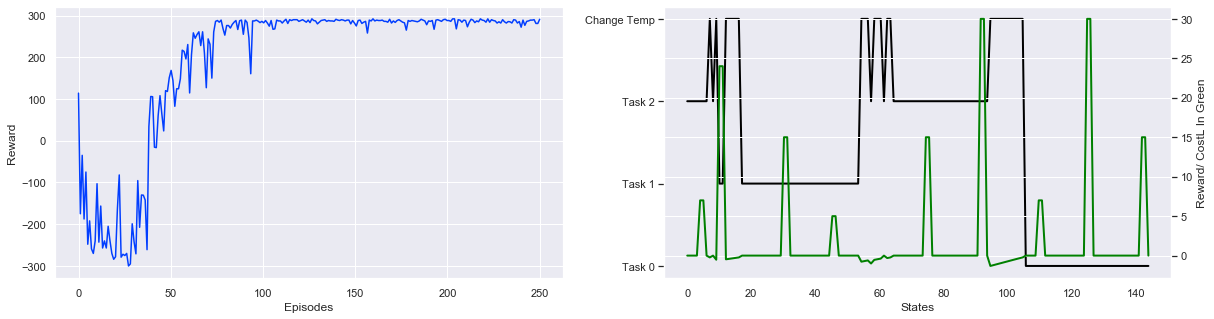

In [314]:
random.seed(100)
#env = Environment()
H = Human(statemap, lr=0.001, gamma=0.9, r_lr=0.8)
score0 = []
trigger = 0
eps = 250
threshold = 293
sns.set(palette='bright')
for i in range(eps):
    #temp = env.reset()
    H.reset(15)
    H.MAXQ_HO(6, 0, None)
    H.decay(i, eps)
    score0.append(H.sum)
    if H.sum>threshold:
        trigger += 1
        if trigger > 20:
            break
    if i%5==0:
        print(i, H.sum) 
logPlot()

4.725273604437187e-08

In [ ]:
states = []
for task in range(3):
    for t in range(15, 30, 1):
        for i in range(30, 70, 5):
            pairState = int(str(t)+str(i))+(task)
            print(t, i, pairState, k)
            k += 1
            states.append(int(pairState))
        
class AI:
    def __init__(self, states, gamma=0.99, lr=0.01):
        self.temp = 0
        self.hum = 50
        self.activity = 0
        self.Q = np.zeros([360, 5])
        self.alpha = lr
        self.alpha_0 = lr
        self.epsilon = 0.5
        self.gamma = gamma
        self.reward = 0
        self.states = states
        self.h_action = 0
    
    def reset(self):
        self.temp = 0
        self.hum = 50
        self.reward = 0
        
    def getState(self, cState):
        val = int(str(self.temp)+str(self.hum))+self.activity
        return self.states.index(val)
        
    def step(self, currS, action, nextS, reward, done):
        nState = self.states.index(nextS)
        cState = self.states.index(currS)
        if done:
                val = np.array((reward))
            else:
                val = np.array((reward + self.gamma*np.max(self.Q[nState, :])))
        self.Q[cState, action] = (1-self.alpha)*self.Q[0, cState,action] + self.alpha*val
        
    def decay(self, x, eps):
        q = 10*x
        self.alpha = self.alpha_0*math.exp(-q/eps)
        self.epsilon = max(0.001, 0.1*math.exp(-q/eps))     
    
    def getAction(self):
        cState = self.getState(self.activity, self.temp, self.hum)
        if random.random() < self.epsilon:
            return random.randint(0, 5), random.randint(0, 5)
        else:
            return np.argmax(self.Q[cState, :])
    
    def reward(self):
        if self.h_action in [0, 1, 2, 3, 4, 5, 11, 12]:
            if aiaction == 0:
                return 0
            else:
                return -1
        elif action in [7, 8, 9, 10]:
            if (aiaction == action - 7):
                return 0
            else:
                return -1
                
       

In [ ]:
H.log_task[100:200]

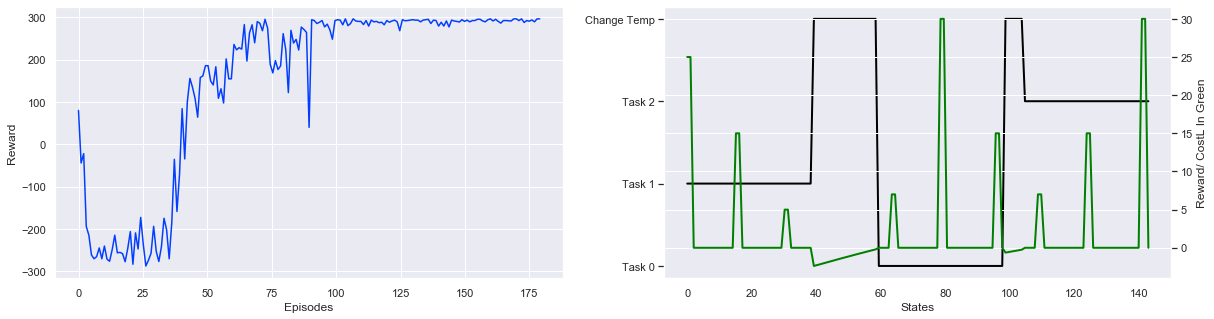

In [313]:
logPlot()

In [ ]:
logPlot()

In [ ]:
j = -3
k = 0
states = set()
for task in range(3):
    for t in range(15, 30, 1):
        for i in range(30, 70, 5):
            pairState = int(str(t)+str(i))+(task)
            print(t, i, pairState, k)
            k += 1
            states.add(int(pairState))

In [236]:
1 - + 2

-1